<span style="font-size: 24px; font-weight: bold;">Question 1</span>


<span style="font-size: 14px; font-weight: bold;">Q: 1(a)</span>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.models as models
from scipy import linalg
import numpy as np

In [2]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Hyperparameters
input_dim = 784  # 28x28
hidden_dim1 = 400
hidden_dim2 = 256
latent_dim = 20
batch_size = 128
epochs = 20
learning_rate = 0.001

In [4]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [5]:
# Define the VAE class
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim2, latent_dim)  # Mean
        self.fc_logvar = nn.Linear(hidden_dim2, latent_dim)  # Log-variance
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, input_dim),
            nn.Sigmoid()  # Output in [0, 1]
        )
    
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # sigma = exp(0.5 * log(sigma^2))
        eps = torch.randn_like(std)  # Sample from N(0, 1)
        return mu + eps * std  # z = mu + sigma * epsilon
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

### VAE Architecture Overview

<small>The Variational Autoencoder (VAE) consists of three main components: an encoder, a latent space with reparameterization, and a decoder. Below is a breakdown of each part:</small>

#### Encoder
- <small>A neural network with two hidden layers that maps input data to a lower-dimensional space.</small>  
- <small>It outputs the mean (`mu`) and log-variance (`logvar`) of the latent distribution.</small>

#### Reparameterization Trick
- <small>To enable backpropagation, a random noise (`epsilon`) is scaled by the standard deviation (`exp(0.5 * logvar)`).</small>  
- <small>This scaled noise is then added to the mean (`mu`), producing a latent vector `z`.</small>

#### Decoder
- <small>Another neural network with two hidden layers that reconstructs the input from the latent vector `z`.</small>  
- <small>The final output uses a Sigmoid activation to ensure values are in the range [0, 1].</small>

#### Overall Functionality
- <small>The VAE learns to encode input data into a structured, continuous latent space.</small>  
- <small>It then reconstructs realistic samples from this latent space, balancing representation and generation capabilities.</small>

In [6]:
# Loss function
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss (binary cross-entropy)
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, input_dim), reduction='sum')
    
    # KL divergence
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE + KL

In [7]:
# Initialize model, optimizer
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# Training loop
vae.train()
for epoch in range(epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss / len(train_loader.dataset):.6f}')

Epoch 1/20, Loss: 181.132914
Epoch 2/20, Loss: 130.648645
Epoch 3/20, Loss: 119.920358
Epoch 4/20, Loss: 114.514677
Epoch 5/20, Loss: 111.373705
Epoch 6/20, Loss: 109.489054
Epoch 7/20, Loss: 107.984724
Epoch 8/20, Loss: 106.812975
Epoch 9/20, Loss: 105.768419
Epoch 10/20, Loss: 104.842957
Epoch 11/20, Loss: 104.204861
Epoch 12/20, Loss: 103.590535
Epoch 13/20, Loss: 103.132207
Epoch 14/20, Loss: 102.698875
Epoch 15/20, Loss: 102.349916
Epoch 16/20, Loss: 101.994200
Epoch 17/20, Loss: 101.713017
Epoch 18/20, Loss: 101.412911
Epoch 19/20, Loss: 101.187073
Epoch 20/20, Loss: 100.982073


<span style="font-size: 14px; font-weight: bold;">Q: 1(b)</span>

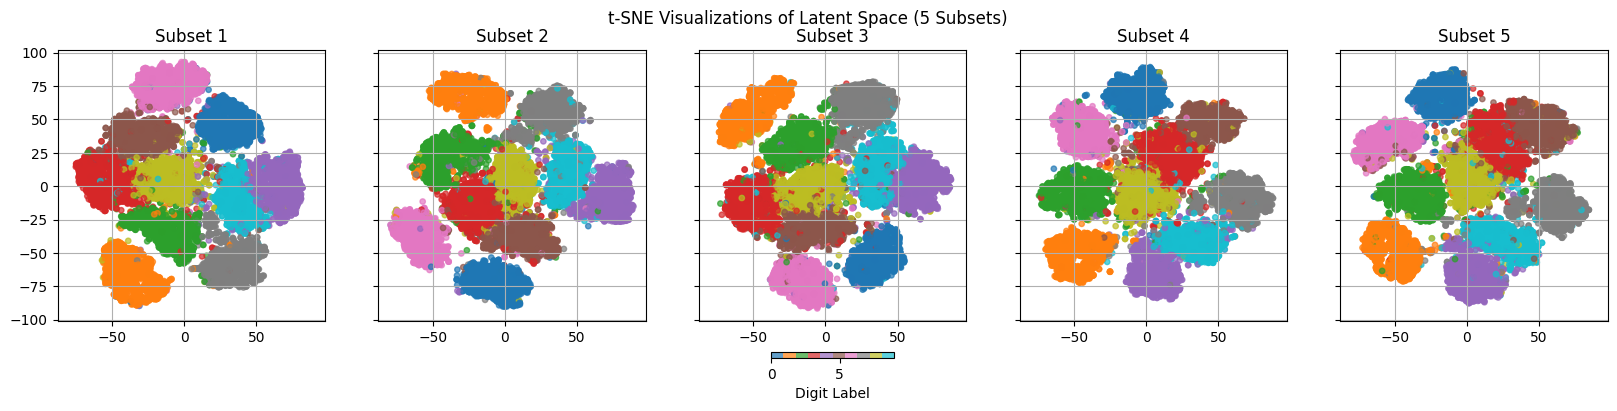

In [18]:
from sklearn.manifold import TSNE

vae.eval()  # Set VAE to evaluation mode
latent_vectors = []
labels = []

with torch.no_grad():
    for data, label in train_loader:
        data = data.to(device)
        mu, _ = vae.encode(data.view(-1, input_dim))
        latent_vectors.append(mu.cpu())
        labels.extend(label.numpy())

latent_vectors = torch.cat(latent_vectors).numpy()
labels = torch.tensor(labels)

# Split data into 5 roughly equal parts
split_size = len(latent_vectors) // 5
subsets = [(latent_vectors[i*split_size:(i+1)*split_size], labels[i*split_size:(i+1)*split_size]) for i in range(5)]

fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharex=True, sharey=True)
fig.suptitle("t-SNE Visualizations of Latent Space (5 Subsets)")

for i, (latent_subset, label_subset) in enumerate(subsets):
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_subset)

    scatter = axes[i].scatter(latent_2d[:, 0], latent_2d[:, 1], c=label_subset, cmap='tab10', alpha=0.7, s=15)
    axes[i].set_title(f'Subset {i + 1}')
    axes[i].grid(True)

fig.colorbar(scatter, ax=axes, orientation='horizontal', fraction=0.02, pad=0.1, label='Digit Label')
plt.show()

#### Importance of Variation in q(z|x)

<small>It's important that the latent distribution `q(z|x)` varies with the conditioning variable `x` because it allows the VAE to capture the underlying structure and variability of the input data. If `q(z|x)` were independent of `x`, the model would learn a single, fixed distribution for all inputs, making it unable to effectively encode the differences between various data points.</small>

<span style="font-size: 14px; font-weight: bold;">Q: 1(c)</span>

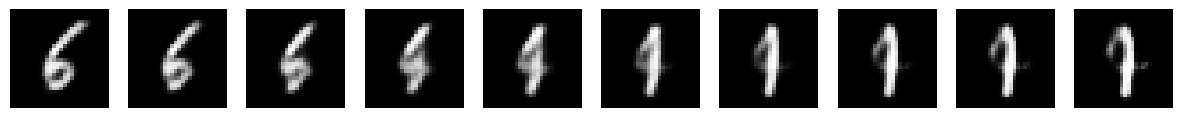

In [25]:
# Function to visualize latent space interpolation
def visualize_latent_interpolation(vae, device, latent_dim, num_samples=10):
    vae.eval()
    with torch.no_grad():
        # Generate two random points in the latent space
        z1 = torch.randn(1, latent_dim).to(device)
        z2 = torch.randn(1, latent_dim).to(device)
        
        # Interpolate between the two points
        z_interpolated = torch.cat([z1 * (1 - alpha) + z2 * alpha for alpha in np.linspace(0, 1, num_samples)], dim=0)
        
        # Decode the interpolated points
        samples = vae.decode(z_interpolated).cpu().view(-1, 28, 28)
        
        # Plot the results
        fig, axes = plt.subplots(1, num_samples, figsize=(15, 2))
        for i, ax in enumerate(axes):
            ax.imshow(samples[i], cmap='gray')
            ax.axis('off')
        plt.show()

# Visualize latent space interpolation
visualize_latent_interpolation(vae, device, latent_dim)

<small> Yes, "nearby" samples in the latent space correspond to "similar" samples in the image space.The encoder learns to organize the latent space such that similar inputs are mapped to nearby regions. Consequently, interpolation in the latent space often leads to meaningful interpolations in the data space. </small>

<span style="font-size: 14px; font-weight: bold;">Q: 1(d)</span>

In [8]:
# Load MNIST test set
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(mnist_test, batch_size=100, shuffle=True)

# Prepare real images
real_images, _ = next(iter(test_loader))
real_images = real_images.to(device)

# Generate synthetic samples from the VAE
vae.eval()
num_samples = 5000
with torch.no_grad():
    z = torch.randn(num_samples, latent_dim).to(device)
    generated_samples = vae.decode(z).view(-1, 1, 28, 28)

# Load pre-trained Inception V3 model
inception = models.inception_v3(pretrained=True).to(device)
inception.eval()

# Preprocess for Inception V3
def preprocess_for_inception(images):
    images = F.interpolate(images, size=(299, 299), mode='bilinear')
    return torch.cat([images, images, images], dim=1)  # Make 3 channels

# Extract features
def get_inception_features(images, model, batch_size=50):
    features = []
    logits = []
    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch = preprocess_for_inception(images[i:i+batch_size]).to(device)
            pred = model(batch)
            features.append(pred.cpu().numpy())
            logits.append(F.softmax(pred, dim=1).cpu().numpy())
    return np.concatenate(features), np.concatenate(logits)

real_features, real_logits = get_inception_features(real_images, inception)
gen_features, gen_logits = get_inception_features(generated_samples, inception)

# Compute Inception Score (IS)
def compute_inception_score(logits, eps=1e-16):
    p = logits
    p_mean = p.mean(axis=0, keepdims=True)
    kl = (p * (np.log(p + eps) - np.log(p_mean + eps))).sum(axis=1)
    return np.exp(kl.mean())

is_score = compute_inception_score(gen_logits)
print(f'Inception Score (IS): {is_score:.4f}')

# Compute FID
def compute_fid(real_feats, gen_feats):
    mu_real, sigma_real = np.mean(real_feats, axis=0), np.cov(real_feats, rowvar=False)
    mu_gen, sigma_gen = np.mean(gen_feats, axis=0), np.cov(gen_feats, rowvar=False)
    mu_diff = mu_real - mu_gen
    cov_mean = linalg.sqrtm(sigma_real @ sigma_gen, disp=False)[0]
    if np.iscomplexobj(cov_mean):
        cov_mean = cov_mean.real
    fid = mu_diff @ mu_diff + np.trace(sigma_real + sigma_gen - 2 * cov_mean)
    return fid

fid_score = compute_fid(real_features, gen_features)
print(f'Fréchet Inception Distance (FID): {fid_score:.4f}')

/home/akshay/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/akshay/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception Score (IS): 2.2325
Fréchet Inception Distance (FID): 381.3449


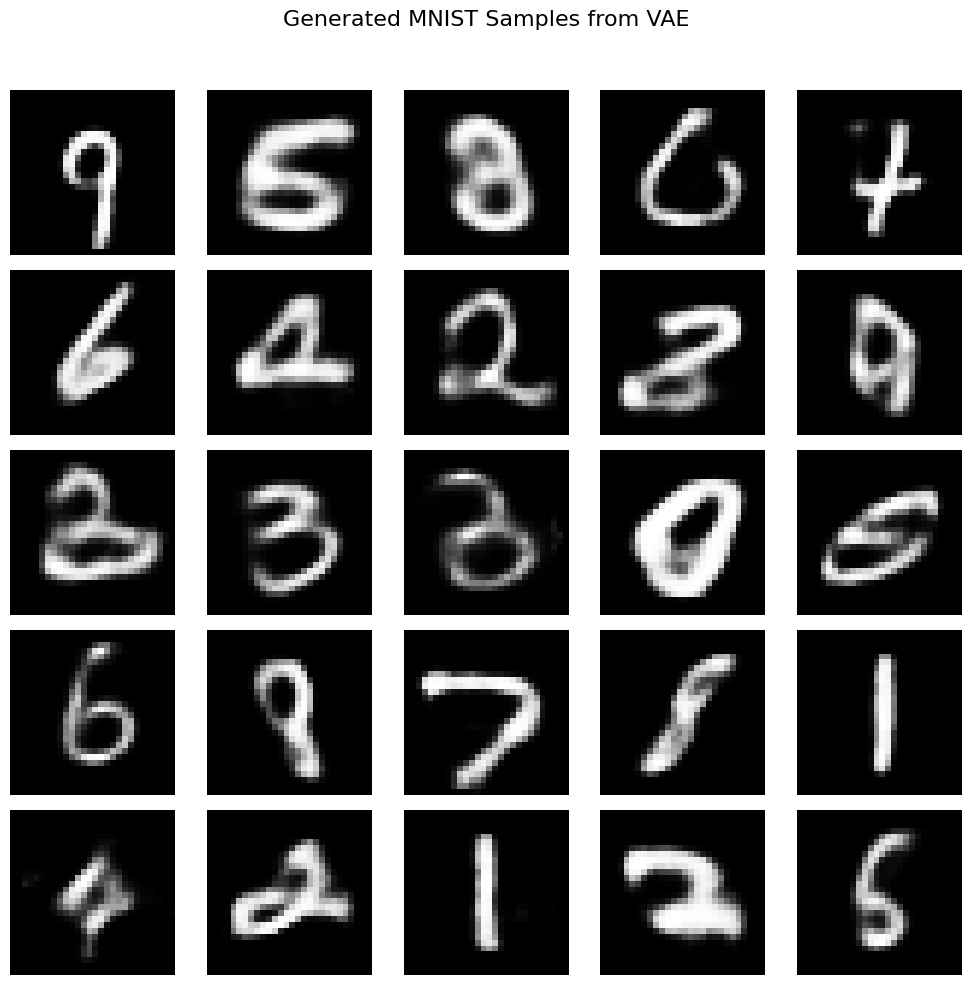

In [10]:
import matplotlib.pyplot as plt

# Qualitative evaluation: Visualize generated samples
plt.figure(figsize=(10, 10))
plt.suptitle(f"Generated MNIST Samples from VAE", fontsize=16)
for i in range(25):  # 5x5 grid
    plt.subplot(5, 5, i + 1)
    plt.imshow(generated_samples[i].view(28, 28).cpu().numpy(), cmap="gray")
    plt.axis("off")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("vae_generated_samples_inception_fid.png")
plt.show()